In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import utils
from scipy.optimize import least_squares, curve_fit, minimize, differential_evolution
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from DataLoader import DataLoader
import datetime as dt
import joblib as joblib
import Calibration as calibration

import warnings
warnings.filterwarnings("ignore")

In [4]:
start, end = "20060225", "20230831"
loader = DataLoader("./data", "csv")
df = loader.load_dates(start, end).sort('Date')[:, 1:]
df = loader.filter_maturities(df, 5)
dates = df['Date'].unique().to_list()

In [13]:
def calibration_jim(texps, h, _eta):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        calibration.sigma_jim(texp, _eta, hurst) for texp in texps
    ])
    return sigma_model


def calibration_h_jim(texps, h):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        calibration.sigma_jim(texp, eta, hurst) for texp in texps
    ])
    return sigma_model

# Parameters
H = utils.Hurst(0.07)
eta = 1.9
volvol = eta * np.sqrt(H.h2) / (utils.c_h(H) * 2)

def calibrate_one_day(dd):
    _df = df.filter(pl.col('Date') == dd).to_pandas().set_index('Date')
    if _df.empty:
        return np.array([np.nan, np.nan])
    # address expirations with single obs
    single_texp = _df.groupby('Texp')['Texp'].count()
    single_texp = set(single_texp[single_texp == 1].index)
    _df = _df[~_df['Texp'].isin(single_texp)]
    
    exp_dates = _df['Expiry'].unique()
    texp_array = _df['Texp'].unique()

    # true values
    sigma = np.array([
        calibration.sigma_market(_df, exp) for exp in exp_dates
    ])

    # calibrate - we try 2-parameter calibration and if it fails
    # we just fit H
    obj = lambda x: np.sum((sigma - calibration_jim(texp_array, x[0], x[1]))**2)
    # options = {'eps': 1e-7}
    opt = differential_evolution(
        obj, x0=np.array([0.07, eta]),
        bounds=((0., 1.), (0., 1000.)),
        # options=options
    )
    if opt.success:
        params = opt.x
        params = np.concatenate((opt.x, [0.0]))
        loss = opt.fun
    else:
        print(f"CAPRA!!!!! NON SAI FARE NULLA! ({dd})")
        obj = lambda x: np.sum((sigma - calibration_h_jim(texp_array, x[0]))**2)
        opt = differential_evolution(
            obj, x0=np.array([0.07]),
            bounds=[(0., 1.)]
        )
        if not opt.success:
            print(f"CAPRA!!!!! NON SAI FARE PROPRIO NULLA! ({dd})rrr")
            arr = np.empty(2) * np.nan
            params = np.concatenate((arr, [2.0]))
            loss = np.inf
        else:
            params = np.concatenate((opt.x, [np.nan], [1.0]))
            loss = opt.fun
    
    return params, loss


In [14]:
calibrated_params = joblib.Parallel(n_jobs=-1, verbose=5)(
    joblib.delayed(calibrate_one_day)(dd) for dd in dates
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s


CAPRA!!!!! NON SAI FARE NULLA! (2006-03-20 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2006-03-14 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2006-03-28 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2006-04-03 00:00:00)


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.5min
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  callIntegral, _ = quad(
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  callIntegral, _ = quad(
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.7min
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The occurrence of roundoff error is detected, which preven

In [15]:
params = [x[0] for x in calibrated_params]
loss = [x[1] for x in calibrated_params]

In [20]:
params.loc[params.err_code !=0 ]

,H,eta,err_code
2006-03-14,0.694587,NaN,1.0
2006-03-20,0.673475,NaN,1.0
2006-03-28,0.598566,NaN,1.0
2006-04-03,0.605040,NaN,1.0


In [22]:
params.describe()

,H,eta,err_code
count,4389.000000,4385.000000,4389.000000
mean,0.052630,10.340183,0.000911
std,0.079338,15.538858,0.030179
min,0.000006,1.020737,0.000000
25%,0.005346,2.275227,0.000000
50%,0.013551,4.208190,0.000000
75%,0.075770,7.823558,0.000000
max,0.932822,203.447619,1.000000


In [48]:
params.fillna(1.9).apply(
    lambda x: x.clip(*np.percentile(x, (1, 99)))
).describe()

,H,eta,err_code
count,4389.000000,4389.000000,4389.0
mean,0.051188,10.227190,0.0
std,0.071094,14.935770,0.0
min,0.000092,1.138483,0.0
25%,0.005346,2.271174,0.0
50%,0.013551,4.205281,0.0
75%,0.075770,7.823092,0.0
max,0.306935,68.070226,0.0


In [ ]:
params.clip().describe()

,H,eta,err_code
count,4389.000000,4385.000000,4389.000000
mean,0.052630,10.307200,0.000911
std,0.079338,15.256089,0.030179
min,0.000006,1.020737,0.000000
25%,0.005346,2.275227,0.000000
50%,0.013551,4.208190,0.000000
75%,0.075770,7.823558,0.000000
max,0.932822,99.000000,1.000000


In [16]:
params = pd.DataFrame(params, index=dates, columns=['H', 'eta', 'err_code'])
params.to_parquet(f'params_diffevo_{start}_{end}.parquet')

In [49]:
params_clip = params.fillna(1.9).apply(
    lambda x: x.clip(*np.percentile(x, (1, 99)))
)

In [36]:
loss = pd.Series(loss, index=dates)

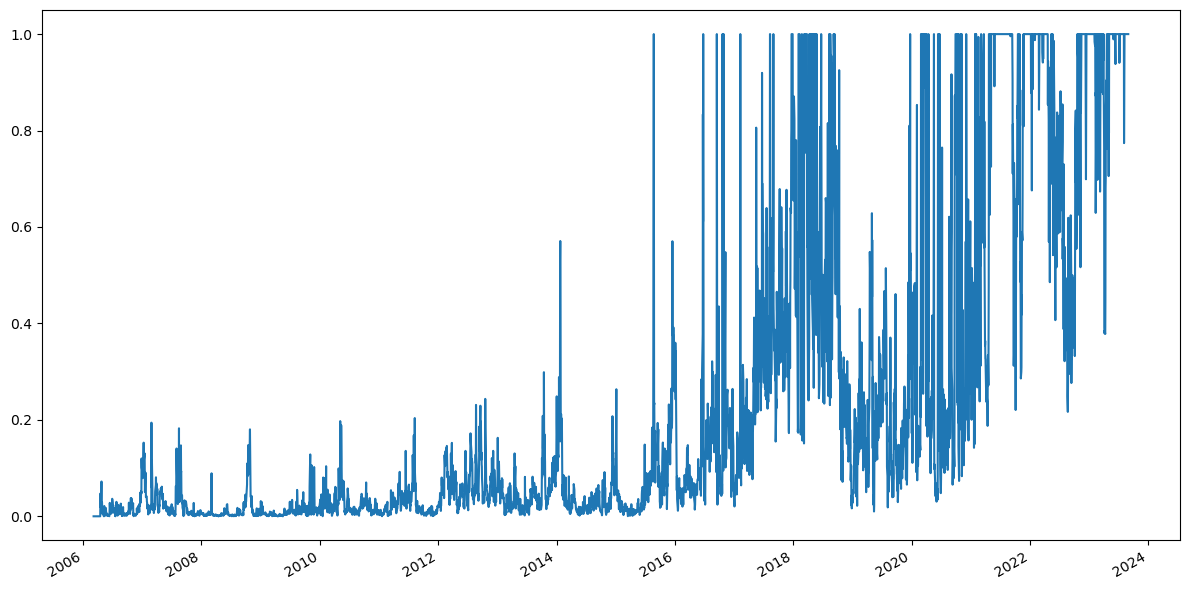

In [39]:
loss.clip(0, 1).plot(figsize=(12, 6))
plt.tight_layout(); plt.show()

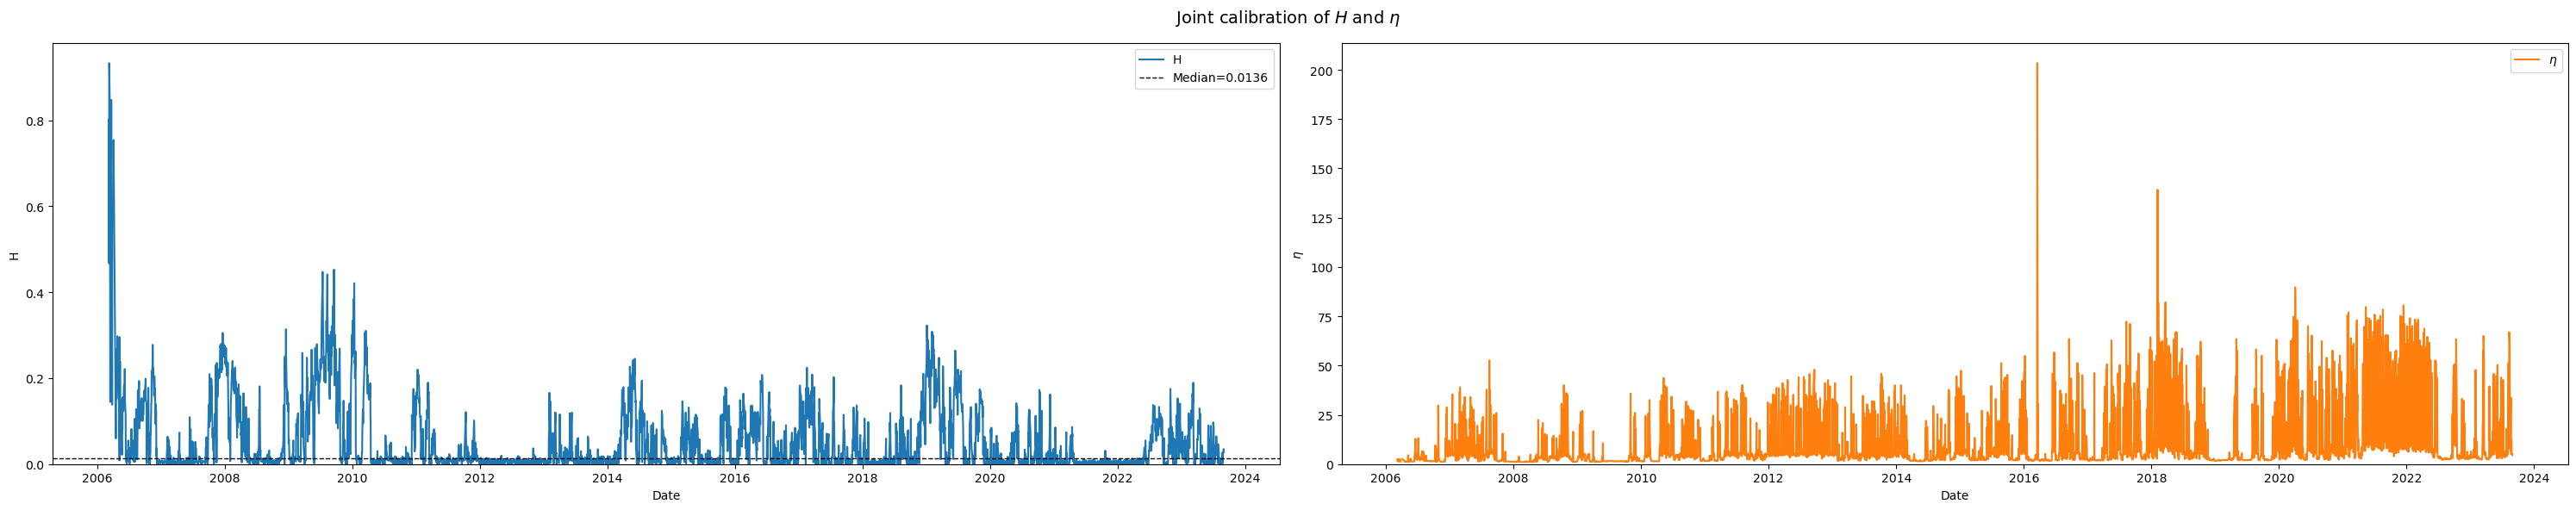

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params['H'], label='H', color='C0')
axs[0].axhline(params['H'].median(), ls='--', color='black', lw=1, label=f'Median={params["H"].median():.4f}')
axs[1].plot(params['eta'], label=r'$\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylim(bottom=0)

fig.tight_layout()
plt.savefig(f"./Plots/diffevo_params_{start}_{end}.png")
plt.show()

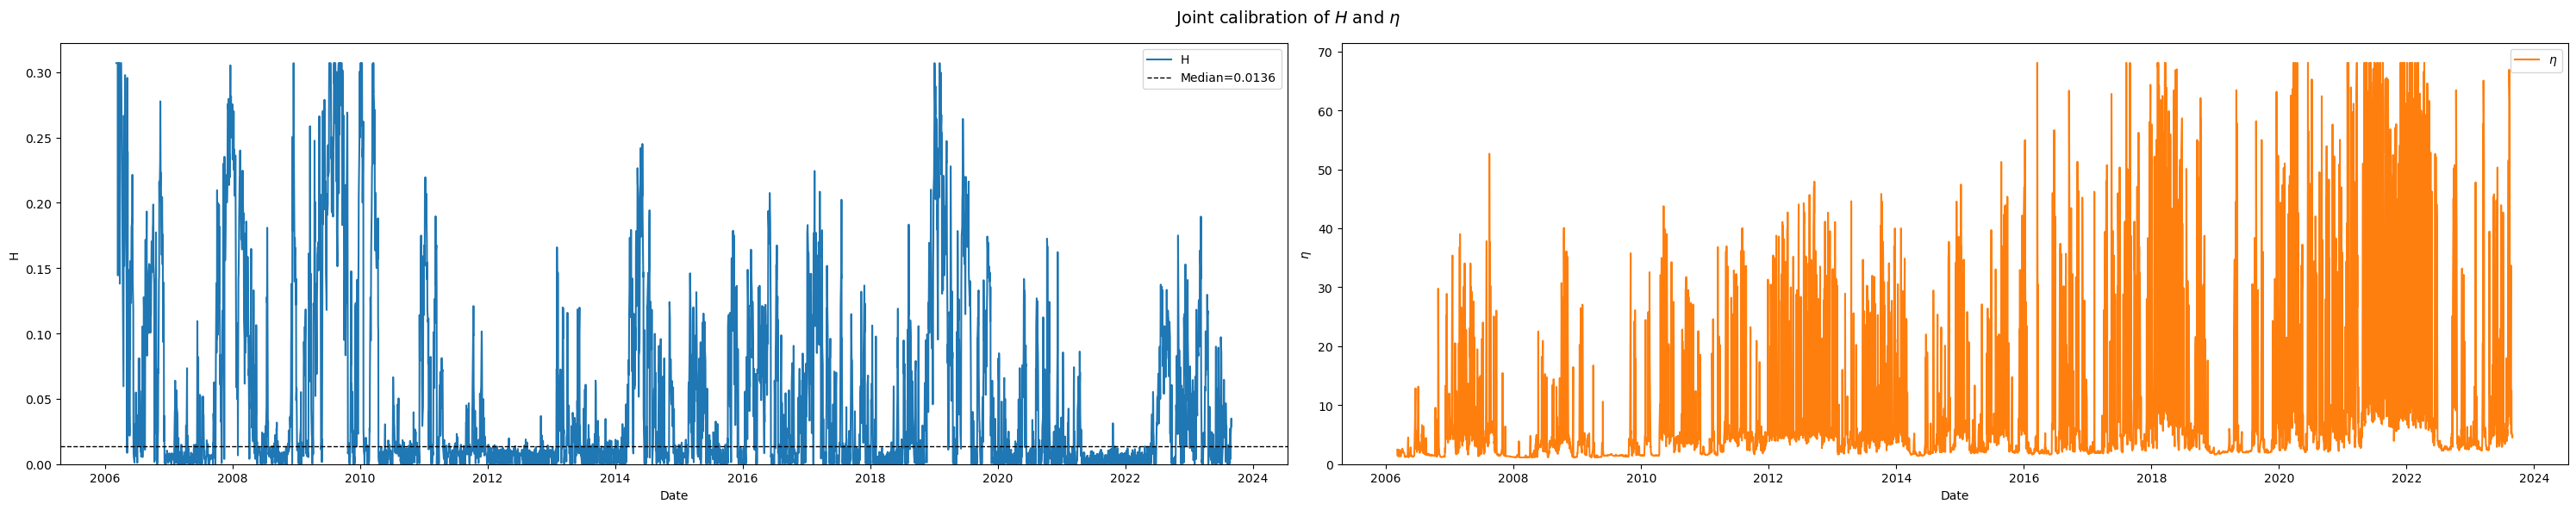

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params_clip['H'], label='H', color='C0')
axs[0].axhline(params_clip['H'].median(), ls='--', color='black', lw=1, label=f'Median={params_clip["H"].median():.4f}')
axs[1].plot(params_clip['eta'], label=r'$\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylim(bottom=0)

fig.tight_layout()
plt.show()

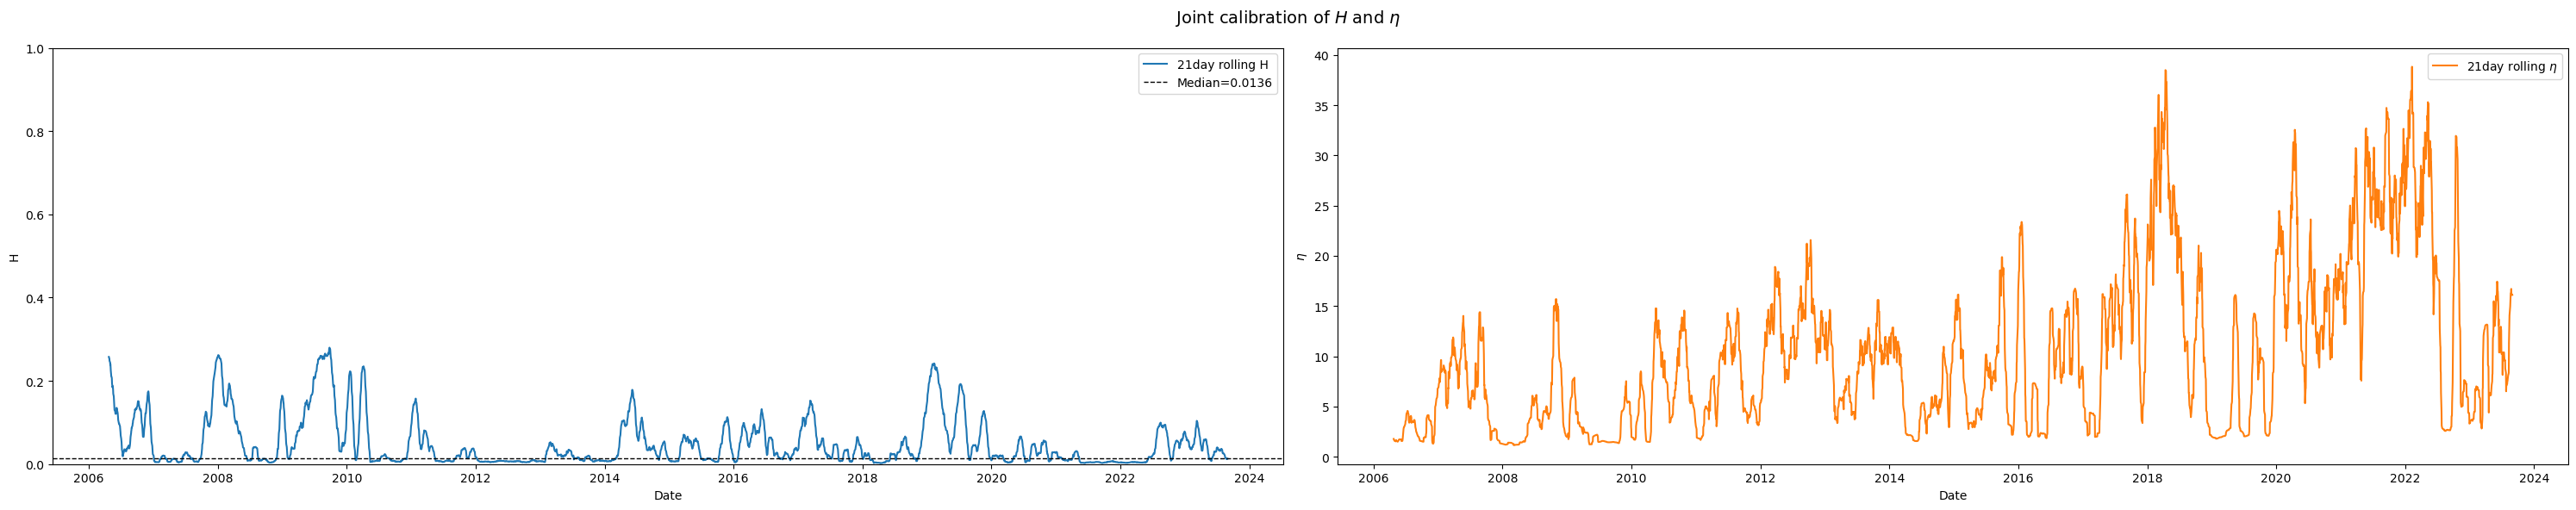

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params_clip['H'].rolling(21).mean(), label='21day rolling H', color='C0')
axs[0].axhline(params_clip['H'].median(), ls='--', color='black', lw=1, label=f'Median={params["H"].median():.4f}')
axs[1].plot(params_clip['eta'].fillna(1.9).rolling(21).mean(), label=r'21day rolling $\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
axs[0].set_ylim(0, 1)
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")

fig.tight_layout()
plt.show()

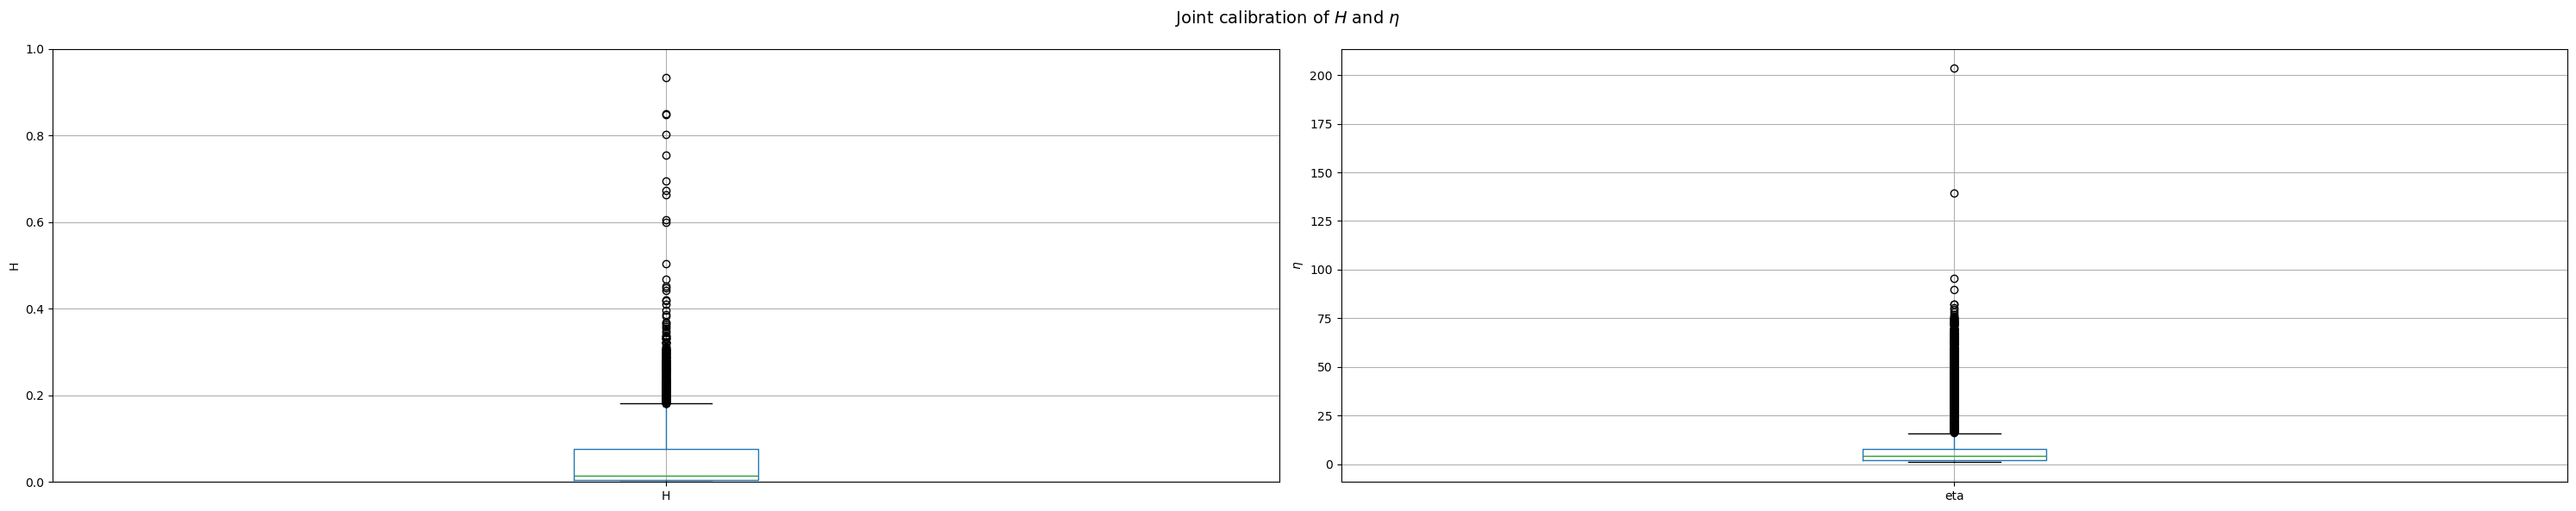

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

params[['H']].boxplot(ax=axs[0])
params[['eta']].boxplot(ax=axs[1])
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
axs[0].set_ylim(0, 1)

fig.tight_layout()
plt.show()

In [55]:
sub_dates = params.index[params['err_code'] != 0].to_list()

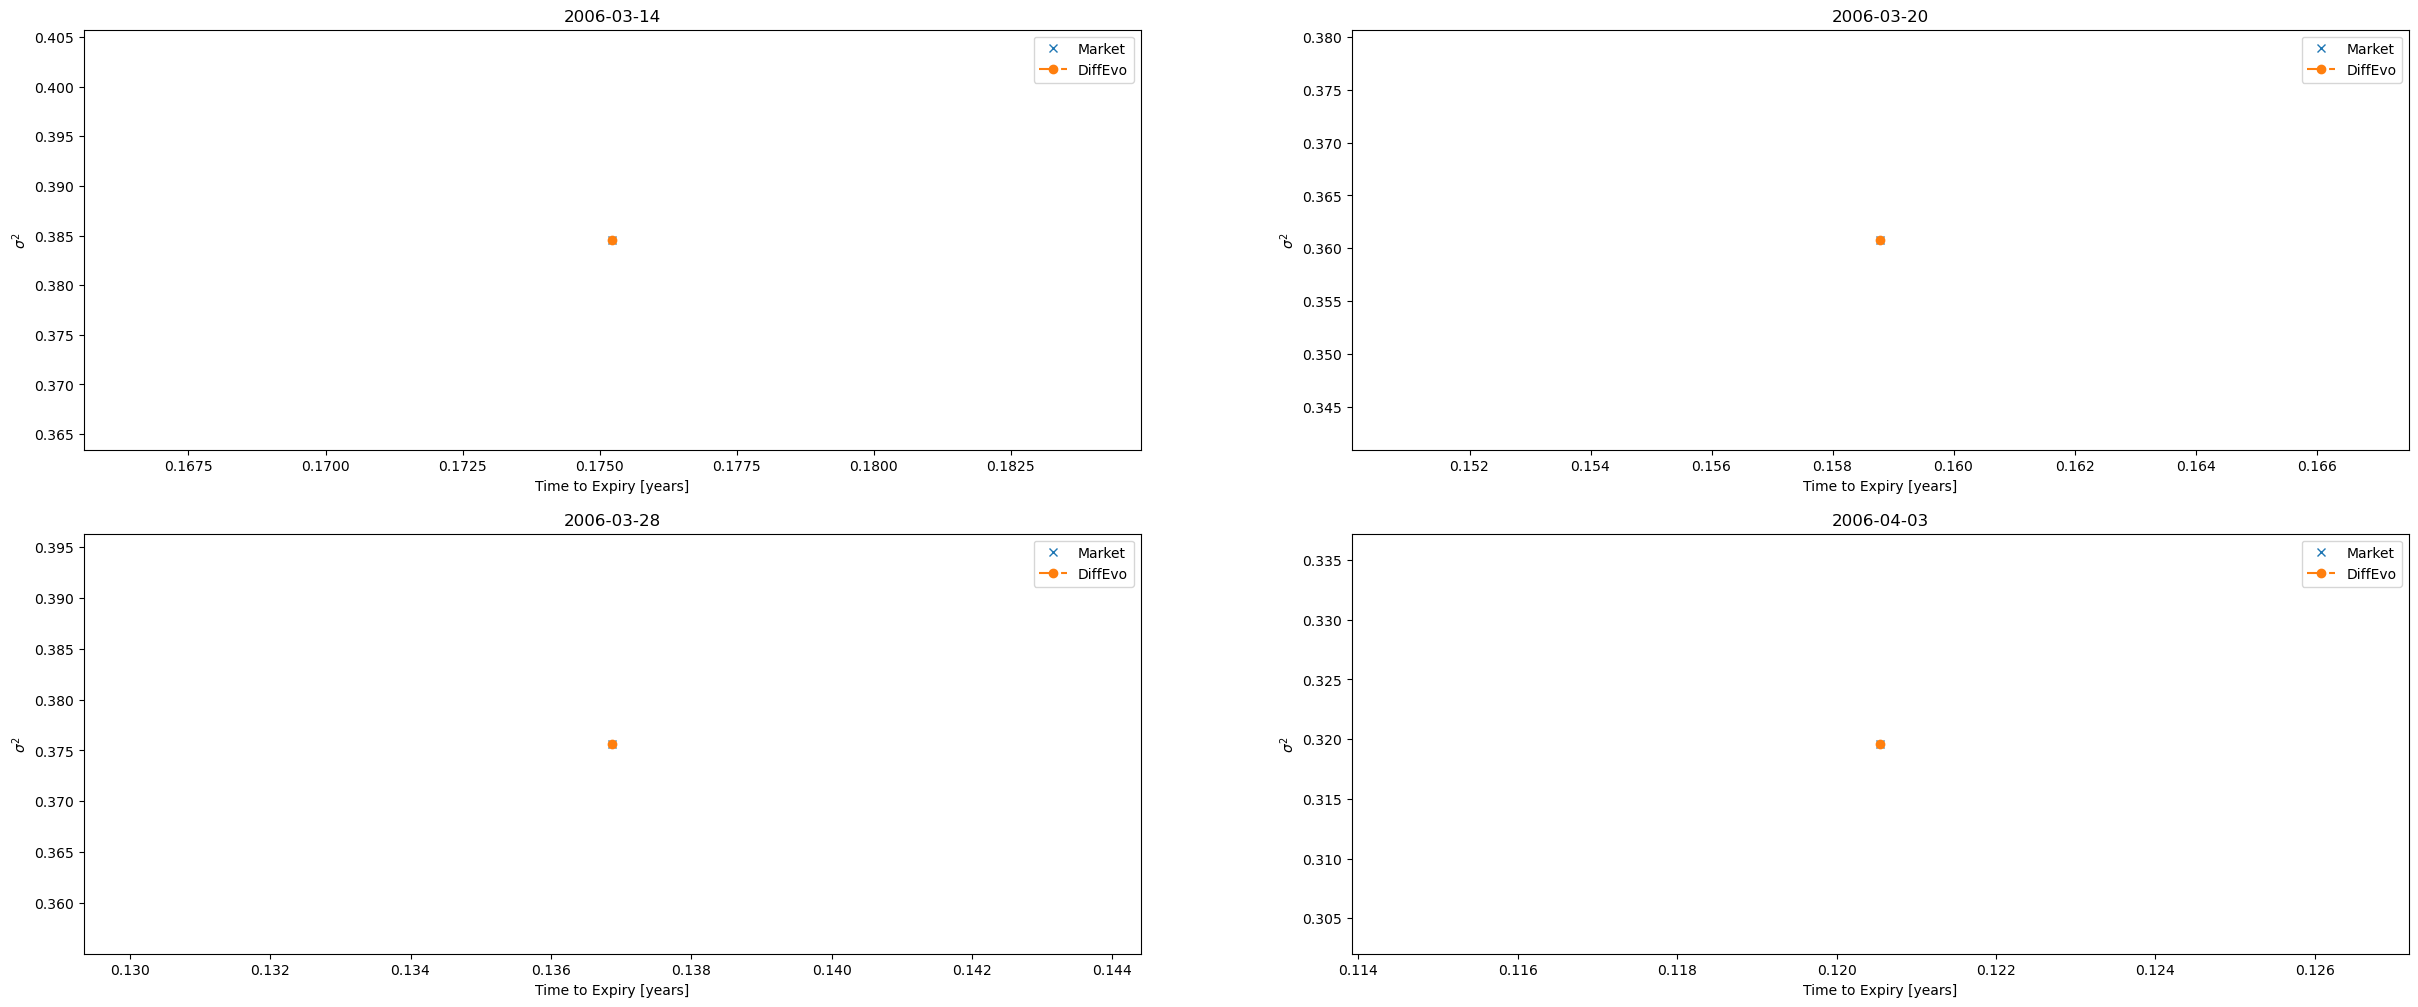

In [76]:
fig, axs = plt.subplots(2, 2, figsize=(30, 12))
axs = axs.flatten()

for i, d in enumerate(sub_dates):
    _df = df.filter(pl.col('Date') == d).to_pandas().set_index('Date')
    exp_dates = _df['Expiry'].unique()
    texp_array = _df['Texp'].unique()

    sigma = np.array([
        calibration.sigma_market(_df, exp) for exp in exp_dates
    ])

    sigma_devo = calibration_jim(texp_array, *params.fillna(1.9).loc[d, ['H', 'eta']])

    axs[i].plot(texp_array, sigma, label='Market', lw=0, marker='x')
    axs[i].plot(texp_array, sigma_devo, label='DiffEvo', marker='o', ls='-.')
    axs[i].legend()
    axs[i].set_xlabel('Time to Expiry [years]'); axs[i].set_ylabel(r"$\sigma^2$")
    axs[i].set_title(f'{d.strftime("%Y-%m-%d")}')

plt.show()

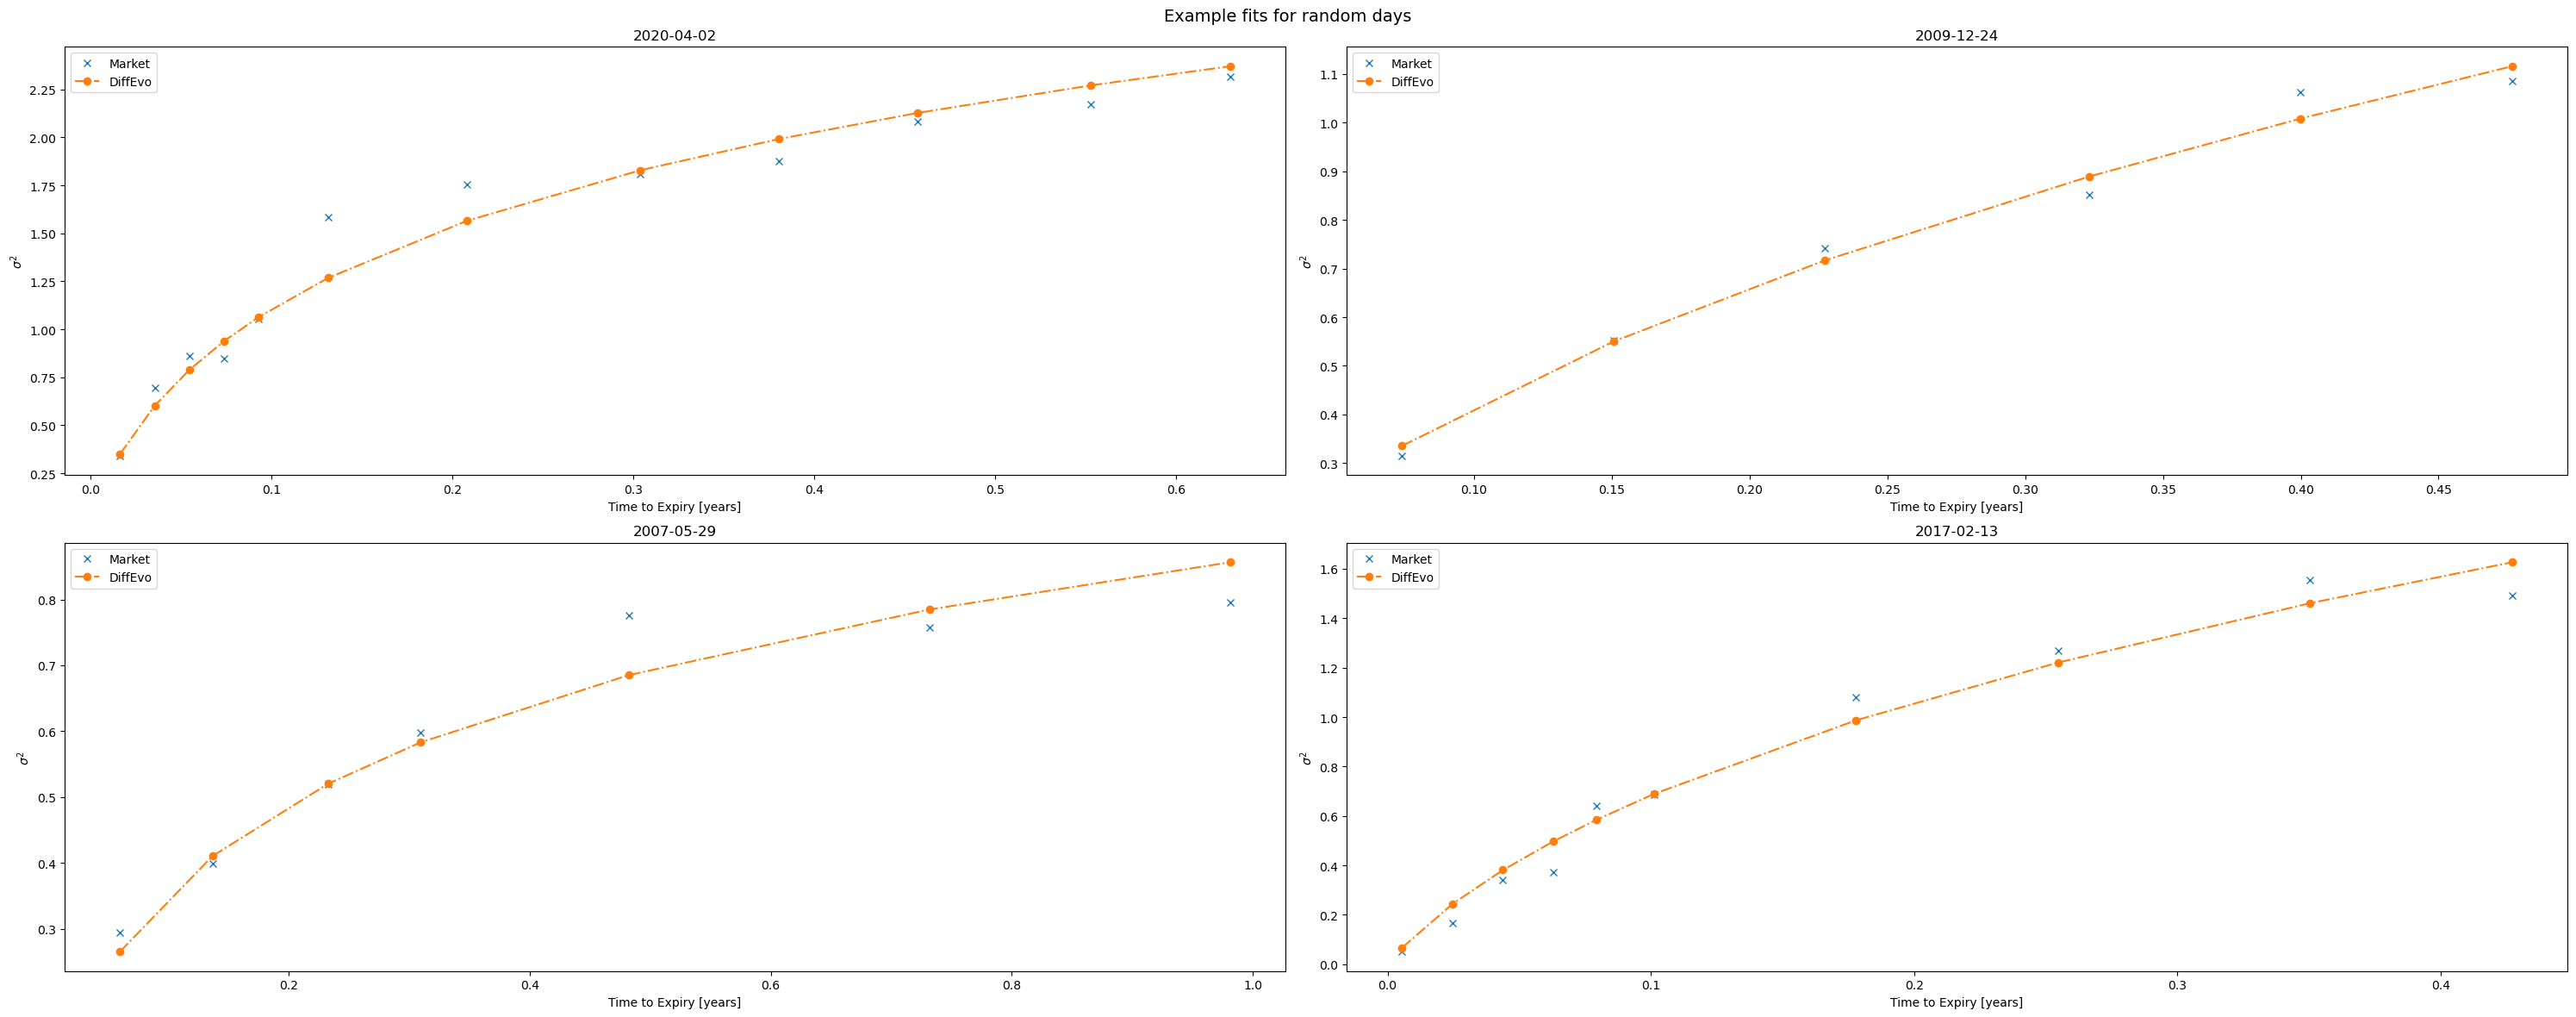

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(30, 12))
axs = axs.flatten()
fig.suptitle("Example fits for random days", fontsize=14)

for i, d in enumerate(np.random.choice(dates, 4)):
    _df = df.filter(pl.col('Date') == d).to_pandas().set_index('Date')
    exp_dates = np.sort(_df['Expiry'].unique())
    texp_array = np.sort(_df['Texp'].unique())

    sigma = np.array([
        calibration.sigma_market(_df, exp) for exp in exp_dates
    ])

    sigma_devo = calibration_jim(texp_array, *params.fillna(1.9).loc[d, ['H', 'eta']])

    axs[i].plot(texp_array, sigma, label='Market', lw=0, marker='x')
    axs[i].plot(texp_array, sigma_devo, label='DiffEvo', marker='o', ls='-.')
    axs[i].legend()
    axs[i].set_xlabel('Time to Expiry [years]'); axs[i].set_ylabel(r"$\sigma^2$")
    axs[i].set_title(f'{d.strftime("%Y-%m-%d")}')

fig.tight_layout()
plt.show()